## U-233 Fueled Breeder Reactor
This notebook will implement a hex-lattice seed/blanket arrangement.  The seed will be U-233, the blanket will be either natural uranium, depleted uranium, or thorium.

In [1]:
import openmc
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# define seed material
seed = openmc.Material(name='seed');
seed.set_density('g/cm3',10.45);
enr = 0.04
seed.add_nuclide('U233',enr,percent_type='ao');
seed.add_nuclide('U238',1.-enr,percent_type='ao');
seed.add_nuclide('O16',2.0);

# blanket - use natural uranium metal
blanket = openmc.Material(name='blanket');
blanket.set_density('g/cm3',19.1);
blanket.add_element('U',1);

# just use elemental Zirconium for clad.
clad = openmc.Material(name='clad');
clad.add_element('Zr',1);
clad.set_density('g/cm3',6.0);

mod = openmc.Material(name='moderator');
mod.add_element('O',1);
mod.add_element('H',2);
moderator_density = 0.712;
mod.set_density('g/cm3',moderator_density); #high temperature density
mod.add_s_alpha_beta('c_H_in_H2O');

materials = openmc.Materials([seed,blanket,clad,mod]);
materials.export_to_xml();

In [3]:
# We will simplify the geometry somewhat by eliminating the clad/fuel gap
h_core = 500.;

r_seed = 0.4; # cm
r_clad = 0.5; # cm
r_blanket = 0.5; # cm

# define surfaces for the seed fuel and cladding
seed_fuel = openmc.ZCylinder(r=r_seed);
seed_clad = openmc.ZCylinder(r=r_clad);
seed_fuel_cell = openmc.Cell(fill=seed,region=-seed_fuel);

seed_fuel_cell.temperature = 1000. + 273.;

seed_clad_cell = openmc.Cell(fill=clad,region=+seed_fuel & -seed_clad);

seed_clad_cell.temperature = 500. + 273.;

seed_mod_cell = openmc.Cell(fill=mod,region=+seed_clad);
seed_pin_universe = openmc.Universe(cells=(seed_fuel_cell,
                                          seed_clad_cell,
                                          seed_mod_cell));

blanket_fuel = openmc.ZCylinder(r=r_blanket);
blanket_fuel_cell = openmc.Cell(fill=blanket,region=-blanket_fuel);
blanket_fuel_cell.temperature = 400. + 273.;

blanket_mod_cell = openmc.Cell(fill=mod,region=+blanket_fuel);
blanket_pin_universe = openmc.Universe(cells=(blanket_fuel_cell,
                                             blanket_mod_cell));

all_mod_cell = openmc.Cell(fill=mod);
outer_universe = openmc.Universe(cells=(all_mod_cell,));

In [4]:
lattice = openmc.HexLattice()
lattice.center = (0.,0.);
lattice.orientation = 'x';
P_D = 1.2;
lattice.pitch = (P_D*(2.0*r_clad),);
lattice.outer = outer_universe;

print(lattice.show_indices(num_rings=6))

                              (0, 0)
                        (0,29)      (0, 1)
                  (0,28)      (1, 0)      (0, 2)
            (0,27)      (1,23)      (1, 1)      (0, 3)
      (0,26)      (1,22)      (2, 0)      (1, 2)      (0, 4)
(0,25)      (1,21)      (2,17)      (2, 1)      (1, 3)      (0, 5)
      (1,20)      (2,16)      (3, 0)      (2, 2)      (1, 4)
(0,24)      (2,15)      (3,11)      (3, 1)      (2, 3)      (0, 6)
      (1,19)      (3,10)      (4, 0)      (3, 2)      (1, 5)
(0,23)      (2,14)      (4, 5)      (4, 1)      (2, 4)      (0, 7)
      (1,18)      (3, 9)      (5, 0)      (3, 3)      (1, 6)
(0,22)      (2,13)      (4, 4)      (4, 2)      (2, 5)      (0, 8)
      (1,17)      (3, 8)      (4, 3)      (3, 4)      (1, 7)
(0,21)      (2,12)      (3, 7)      (3, 5)      (2, 6)      (0, 9)
      (1,16)      (2,11)      (3, 6)      (2, 7)      (1, 8)
(0,20)      (1,15)      (2,10)      (2, 8)      (1, 9)      (0,10)
      (0,19)      (1,14)      (2, 9)      (1,10)

In [5]:
center_ring = [seed_pin_universe];
ring_1 = [seed_pin_universe]*6;
ring_2 = [seed_pin_universe]*12;
ring_3 = [seed_pin_universe]*18;
ring_4 = [blanket_pin_universe]*24;
ring_5 = [blanket_pin_universe]*30;

lattice.universes = [ring_5,
                    ring_4,
                    ring_3,
                    ring_2,
                    ring_1,
                    center_ring]
print(lattice)

HexLattice
	ID             =	4
	Name           =	
	Orientation    =	x
	# Rings        =	6
	# Axial        =	None
	Center         =	(0.0, 0.0)
	Pitch          =	(1.2,)
	Outer          =	3
	Universes      
     2 2 2 2 2 2
    2 2 2 2 2 2 2
   2 2 1 1 1 1 2 2
  2 2 1 1 1 1 1 2 2
 2 2 1 1 1 1 1 1 2 2
2 2 1 1 1 1 1 1 1 2 2
 2 2 1 1 1 1 1 1 2 2
  2 2 1 1 1 1 1 2 2
   2 2 1 1 1 1 2 2
    2 2 2 2 2 2 2
     2 2 2 2 2 2


In [6]:
outer_surface = openmc.ZCylinder(r=7.2,boundary_type='reflective')
#outer_surface = openmc.model.hexagonal_prism(
#    edge_length = 6*lattice.pitch[0],
#    orientation='x',
#    boundary_type = 'vacuum');
top_surface = openmc.ZPlane(z0=250.,boundary_type='reflective');
bottom_surface = openmc.ZPlane(z0=-250.,boundary_type='reflective');
main_cell = openmc.Cell(fill=lattice,region = 
                        -outer_surface & +bottom_surface & -top_surface);


geometry = openmc.Geometry([main_cell]);
geometry.export_to_xml()

In [7]:
plot = openmc.Plot.from_geometry(geometry)
plot.color_by = 'material'
plot.colors = colors = {
    mod: 'blue',
    clad: 'grey',
    seed: 'yellow',
    blanket: 'olive'
}
#plot.to_ipython_image()

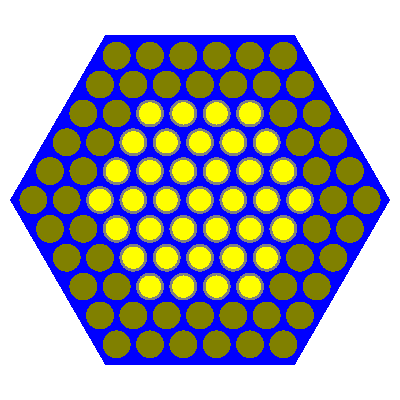

In [8]:
main_cell.region = openmc.model.hexagonal_prism(edge_length=5.7*lattice.pitch[0],
                                                orientation='x',                           
                                                boundary_type='reflective');
geometry.export_to_xml()
plot.to_ipython_image()




In [9]:
seed_filter = openmc.CellFilter(seed_fuel_cell);
blanket_filter = openmc.CellFilter(blanket_fuel_cell);

# set up energy bins
N = 1001;
energy_bins = np.logspace(-3,7,num=N);
energy_filter = openmc.EnergyFilter(values=energy_bins);

# establish seed flux tally
seed_flux = openmc.Tally(name='seed_flux');
seed_flux.scores = ['flux'];
seed_flux.filters = [seed_filter,energy_filter];

# establish blanket flux tally
blanket_flux = openmc.Tally(name='blanket_flux');
blanket_flux.scores = ['flux'];
blanket_flux.filters = [blanket_filter,energy_filter];

fertile_capture = openmc.Tally(name='fertile_total_capture');
fertile_capture.scores = ['(n,gamma)'];
fertile_capture.nuclides=['U238'];
efilter_values = [0.0, 1.0, 3.0e4, 14.0e6]; # OpenMC energy units are eV
efilter_capture = openmc.EnergyFilter(values=efilter_values);
fertile_capture.filters=[efilter_capture];

fissile_abs = openmc.Tally(name='fissile_abs');
fissile_abs.scores = ['absorption'];
fissile_abs.nuclides = ['U233','U235'];
fissile_abs.filters = [efilter_capture];

tallies = openmc.Tallies([seed_flux, blanket_flux,
                          fertile_capture,fissile_abs]);

tallies.export_to_xml();

In [10]:
# establish settings for a criticality calculation
settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 20000;
settings.batches = 200;
settings.inactive = 50;

box = openmc.stats.Box(lower_left=(-3.,-3.,-200.),
                      upper_right = (3.,3.,200.),
                      only_fissionable=True);
src = openmc.Source(space=box);
settings.source = src;

settings.temperature['method'] = 'interpolation';

settings.export_to_xml();

In [11]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      137/1    1.02160    1.00867 +/- 0.00113
      138/1    0.99375    1.00850 +/- 0.00113
      139/1    1.01513    1.00857 +/- 0.00112
      140/1    0.99456    1.00842 +/- 0.00112
      141/1    1.00905    1.00842 +/- 0.00111
      142/1    1.00696    1.00841 +/- 0.00110
      143/1    0.99835    1.00830 +/- 0.00109
      144/1    1.02390    1.00846 +/- 0.00109
      145/1    1.00109    1.00839 +/- 0.00108
      146/1    1.00124    1.00831 +/- 0.00107
      147/1    1.00742    1.00830 +/- 0.00106
      148/1    1.00878    1.00831 +/- 0.00105
      149/1    1.01837    1.00841 +/- 0.00105
      150/1    1.00204    1.00835 +/- 0.00104
      151/1    1.01447    1.00841 +/- 0.00103
      152/1    1.00991    1.00842 +/- 0.00102
      153/1    0.98953    1.00824 +/- 0.00103
      154/1    1.02085    1.00836 +/- 0.00102
      155/1    1.01348    1.00841 +/- 0.00101
      156/1    1.01584    1.00848 +/- 0.00101
      157/1    1.01262    1.00852 +/- 0.00100
      158/1    1.00768    1.00851 

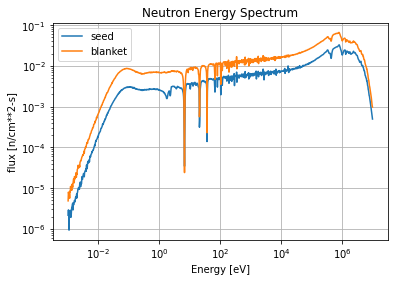

In [12]:
sp = openmc.StatePoint('statepoint.200.h5')
seed_flux_t = sp.get_tally(name='seed_flux');
seed_flux_df = seed_flux_t.get_pandas_dataframe();
seed_flux_vals = seed_flux_df['mean'].to_numpy();

blanket_flux_t = sp.get_tally(name='blanket_flux');
blanket_flux_df = blanket_flux_t.get_pandas_dataframe();
blanket_flux_vals = blanket_flux_df['mean'].to_numpy();

energy_x = 0.5*(energy_bins[0:-1]+energy_bins[1:])

plt.loglog(energy_x,seed_flux_vals,label='seed')
plt.loglog(energy_x,blanket_flux_vals,label='blanket')
plt.grid();
plt.legend();
plt.title('Neutron Energy Spectrum');
plt.xlabel('Energy [eV]');
plt.ylabel('flux [n/cm**2-s]');

In [13]:
fertile_capture = sp.get_tally(name='fertile_total_capture');
fertile_capture_df = fertile_capture.get_pandas_dataframe();

fissile_abs = sp.get_tally(name='fissile_abs');
fissile_abs_df = fissile_abs.get_pandas_dataframe();

In [14]:
fertile_capture_df.head(10)

,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,0.0,1.0,U238,"(n,gamma)",0.091745,0.000128
1,1.0,30000.0,U238,"(n,gamma)",0.367265,0.000298
2,30000.0,14000000.0,U238,"(n,gamma)",0.060892,0.000031


In [15]:
fissile_abs_df.head(10)

,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,0.0,1.0,U233,absorption,0.113228,0.000213
1,0.0,1.0,U235,absorption,0.131023,0.000200
2,1.0,30000.0,U233,absorption,0.090553,0.000126
3,1.0,30000.0,U235,absorption,0.046625,0.000043
4,30000.0,14000000.0,U233,absorption,0.008177,0.000004
5,30000.0,14000000.0,U235,absorption,0.004489,0.000002


In [16]:
total_fertile_capture = fertile_capture_df['mean'].sum()
total_fissile_abs = fissile_abs_df['mean'].sum()

initial_conversion_ratio = total_fertile_capture/total_fissile_abs
print('Initial C = %5.4f' % initial_conversion_ratio);

Initial C = 1.3192
